# Dataset Overview
- **Parasitized:** Infected cell images  
- **Uninfected:** Healthy cell images  

In [15]:
import os
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [23]:
data_dir = "/kaggle/input/malaria-cell-images/cell_images/cell_images"
print("Dataset Folders:", os.listdir(data_dir))

Dataset Folders: ['Uninfected', 'Parasitized']


In [24]:
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

In [25]:
def count_images(directory):
    return len(os.listdir(directory))

In [26]:
print("Parasitized images:", count_images(parasitized_dir))
print("Uninfected images:", count_images(uninfected_dir))

Parasitized images: 13780
Uninfected images: 13780


In [27]:
def plot_sample_images(directory, title):
    img_files = random.sample(os.listdir(directory), 4)
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(title, fontsize=14)
    for i, img_file in enumerate(img_files):
        img = cv2.imread(os.path.join(directory, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

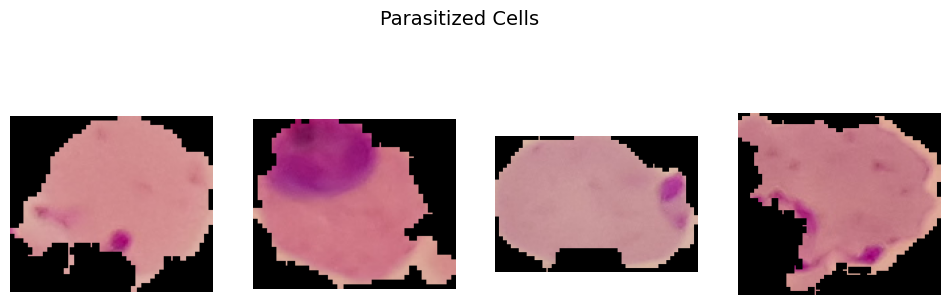

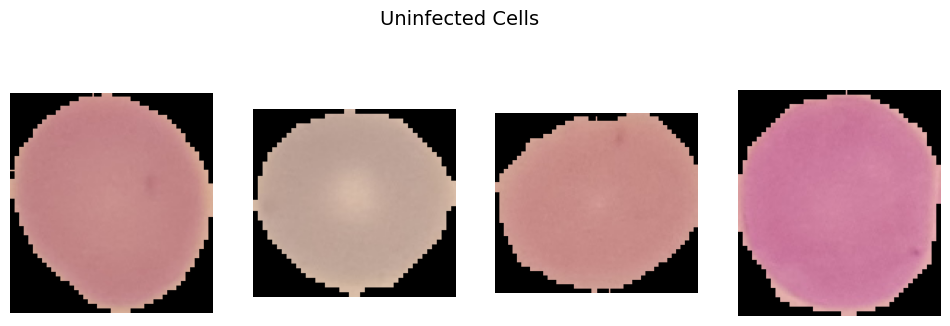

In [28]:
plot_sample_images(parasitized_dir, "Parasitized Cells")
plot_sample_images(uninfected_dir, "Uninfected Cells")

In [29]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Data Preprocessing
- **Augmentations:** Rotation, zoom, flip, rescale  
- **Validation Split:** 20%  

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

In [31]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 22048 images belonging to 2 classes.


In [32]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 5510 images belonging to 2 classes.


# Model Architecture
- **3x Conv2D + MaxPooling**  
- **Flatten → Dense(128) → Dropout(0.4) → Output(sigmoid)**  

In [33]:
def create_malaria_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

In [34]:
model = create_malaria_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training Config
- **Loss:** Binary Crossentropy  
- **Optimizer:** Adam (LR = 0.0001)  
- **Epochs:** 30  

In [35]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_malaria_model.keras', monitor='val_accuracy', save_best_only=True)

In [38]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 138s 194ms/step - accuracy: 0.6024 - loss: 1.4026 - val_accuracy: 0.6216 - val_loss: 0.6495
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 147s 212ms/step - accuracy: 0.6849 - loss: 0.6310 - val_accuracy: 0.8472 - val_loss: 0.4875
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 147s 211ms/step - accuracy: 0.8161 - loss: 0.5105 - val_accuracy: 0.9051 - val_loss: 0.3794
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.8682 - loss: 0.4012 - val_accuracy: 0.9040 - val_loss: 0.3359
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 136s 196ms/step - accuracy: 0.8870 - loss: 0.3539 - val_accuracy: 0.9125 - val_loss: 0.3209
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 148s 213ms/step - accuracy: 0.8900 - loss: 0.3282 - val_accuracy: 0.9091 - val_loss: 0.2947
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 151s 217ms/step - accuracy: 0.8933 - loss: 0.3275 - val_accuracy: 0.9087 - val_loss: 0.2962
Epoch 8/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 136s 196ms/step - accuracy: 0.8955 -

In [39]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.9142 - loss: 0.2621
Validation Loss: 0.2567517161369324
Validation Accuracy: 0.9134301543235779


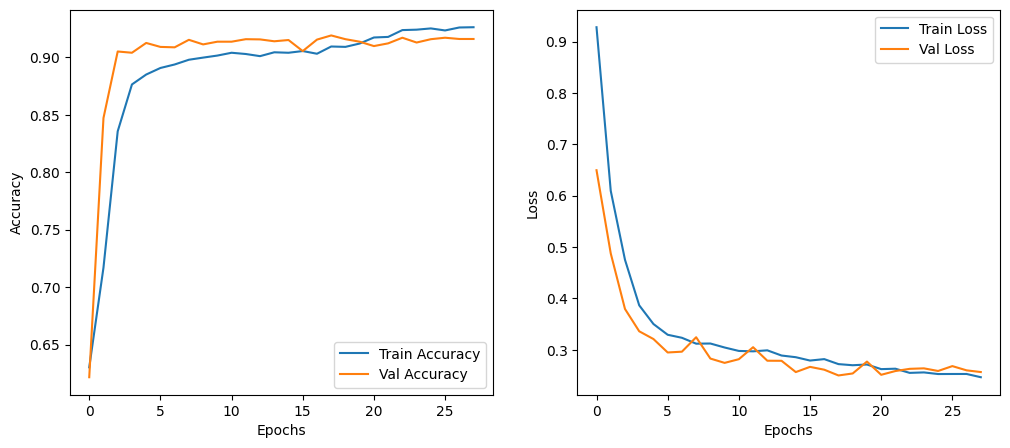

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Results

## Training Performance
- **Final Training Accuracy:** 92.77%  
- **Final Training Loss:** 0.2448  

## Validation Performance
- **Final Validation Accuracy:** 91.34%  
- **Final Validation Loss:** 0.2568  

## Observations
- Validation accuracy is **good**, indicating effective learning.  
- Validation loss is **low**, suggesting the model generalizes well.  
- No significant overfitting observed.
## Next Steps
- **Fine-tune Model** to improve accuracy further.  
- **Experiment with Transfer Learning** for potential performance gains.  
- **Increase Dataset Size** for better generalization.  